# Social Reinforcement Learning Second Level Analyses

## Set Up

### Import packages

In [1]:
import os
import sys
import glob
import pandas as pd
import numpy as np

from matplotlib.gridspec import GridSpec

# Import cerebellum packages
import matplotlib.pyplot as plt
import SUITPy.flatmap as flatmap

from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img, cluster_level_inference

import importlib
import helpful_functions
importlib.reload(helpful_functions)



<module 'helpful_functions' from '/Users/hpopal/Library/CloudStorage/GoogleDrive-hpopal@umd.edu/My Drive/dscn_lab/projects/scon_social_reward/code/neuron_code/helpful_functions.py'>

### Set directories and import subject data

In [42]:
#bids_dir = '/data/neuron/SCN/SR/'
bids_dir = '/Users/hpopal/Google Drive/My Drive/dscn_lab/projects/scon_social_reward/'

os.chdir(bids_dir)

data_dir = os.path.join(bids_dir, 'derivatives','rl_modeling','subject_results')
outp_dir = data_dir+'group/'

# Import scan info for runs that passed QC
subjs_scan_info = pd.read_csv(bids_dir+'/derivatives/participants-qc-min_task_errors.csv')

# Create a participant list for only those with good scans
subjs_list = list(subjs_scan_info['participant_id'].unique())
subjs_list.sort()

# Import other participant info like demographics
subjs_info = pd.read_csv(bids_dir+'/participants.tsv', sep='\t', index_col=0)
#subjs_info = subjs_info.rename(columns={'participant_id': 'subject_label'})

# Filter for only participants with good scan data
#subjs_info = subjs_info.loc[subjs_list]
subjs_info = subjs_info[subjs_info.index.isin(subjs_list)]

# Rename group IDs
subjs_info['group'] = subjs_info['group'].map({1: 'not_asd', 2: 'asd'})

# Reset index to make participant IDs a column
subjs_info = subjs_info.reset_index()

# Filter for learners
#learn_sim_subjs = pd.read_csv(bids_dir+'derivatives/pre_post_task_survey/participants-task-sim_learn.csv')
#subjs_list = list(learn_sim_subjs['participant_id'].unique())
#subjs_list.sort()
#subjs_info = subjs_info[subjs_info['participant_id'].isin(learn_sim_subjs['participant_id'])]

subjs_info_typ = subjs_info[subjs_info['group']=='not_asd']
subjs_info_asd = subjs_info[subjs_info['group']=='asd']
subjs_info_typ = subjs_info_typ.rename(columns={'participant_id': 'subject_label'})
subjs_info_asd = subjs_info_asd.rename(columns={'participant_id': 'subject_label'})

#subjs_list = subjs_info.index.to_list()
subjs_list_typ = subjs_info_typ['subject_label'].to_list()
subjs_list_asd = subjs_info_asd['subject_label'].to_list()

print('Found '+str(len(subjs_list_typ))+' non-autistic participants')
print('Found '+str(len(subjs_list_asd))+' autistic participants')

Found 85 non-autistic participants
Found 28 autistic participants


In [69]:
subjs_info.groupby(['group','gender']).describe()

age                                                        \
               count       mean       std    min      25%     50%      75%   
group   gender                                                               
asd     1       22.0  13.295455  0.871358  11.68  12.6225  13.255  13.9150   
        2        3.0  12.046667  0.485833  11.61  11.7850  11.960  12.2650   
        4        1.0  14.390000       NaN  14.39  14.3900  14.390  14.3900   
        9        2.0  12.440000  1.329361  11.50  11.9700  12.440  12.9100   
not_asd 1       39.0  13.002564  1.250978  11.01  12.0850  12.750  14.1500   
        2       44.0  12.823182  1.311555  11.04  11.5200  12.770  13.9475   
        4        1.0  14.100000       NaN  14.10  14.1000  14.100  14.1000   
        5        1.0  12.160000       NaN  12.16  12.1600  12.160  12.1600   

                       
                  max  
group   gender         
asd     1       14.71  
        2       12.57  
        4       14.39  
        9       13.38  
not_asd 1       14.97  
        2       14.97  
        4       14.10  
        5       12.16

## Non-Autistic Adolescents

<Axes: label='conditions', ylabel='scan number'>

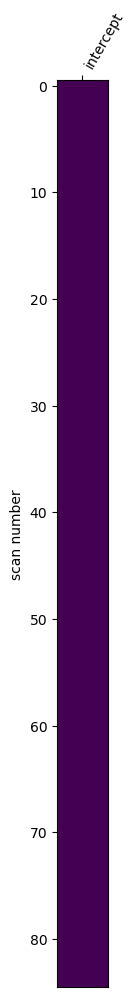

In [62]:
design_matrix = make_second_level_design_matrix(subjs_list_typ)

plot_design_matrix(design_matrix)

In [63]:
mni_mask = bids_dir+"/derivatives/fmriprep/sub-SCN101/anat/sub-SCN101_space-MNIPediatricAsym_cohort-5_res-2_label-GM_probseg_bin.nii.gz"

contrasts=['RPE','RPE_abs','RvL']
group = 'not_asd'
tasks = ['SR']
alpha = 0.005
mc = 'fdr'


threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        temp_subj_list = subjs_list_typ.copy()
        temp_file_list = []
        for subj in subjs_list_typ:
            temp_file = glob.glob(os.path.join(data_dir,subj,
                                               'zmap_'+task+'_'+contrast+'_run-all.nii.gz'))
            if len(temp_file) == 0:
                temp_subj_list.remove(subj)
                continue
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        print('Calculating group '+contrast+' contrast')

        design_matrix = make_second_level_design_matrix(temp_subj_list)
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)

        
        contrast_stats = model.compute_contrast(output_type='all')
        z_map = contrast_stats['z_score']
        e_map = contrast_stats['effect_size']

        z_map.to_filename(os.path.join(data_dir,'../group_results',
                                   group+'_'+task+'_'+contrast+'_zmap.nii.gz'))
        e_map.to_filename(os.path.join(data_dir,'../group_results',
                                   group+'_'+task+'_'+contrast+'_effect.nii.gz'))
            
        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)
        #z_map_thresh_clust = cluster_level_inference(z_map_thresh, alpha=0.05)
        z_map_thresh.to_filename(os.path.join(data_dir,'../group_results',
                                   group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))
        #z_map_thresh_clust.to_filename(os.path.join(data_dir,'group',
        #                           'zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)+'_clust-0.05'+'.nii.gz'))
            
        threshold_data[group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)] = threshold
        
        

Calculating group RPE contrast
Calculating group RPE_abs contrast
Calculating group RvL contrast


### Proof of Concept: Button Press
This is a contrast of button presses vs fixation just to see if we get the motor cortex as would be expected.

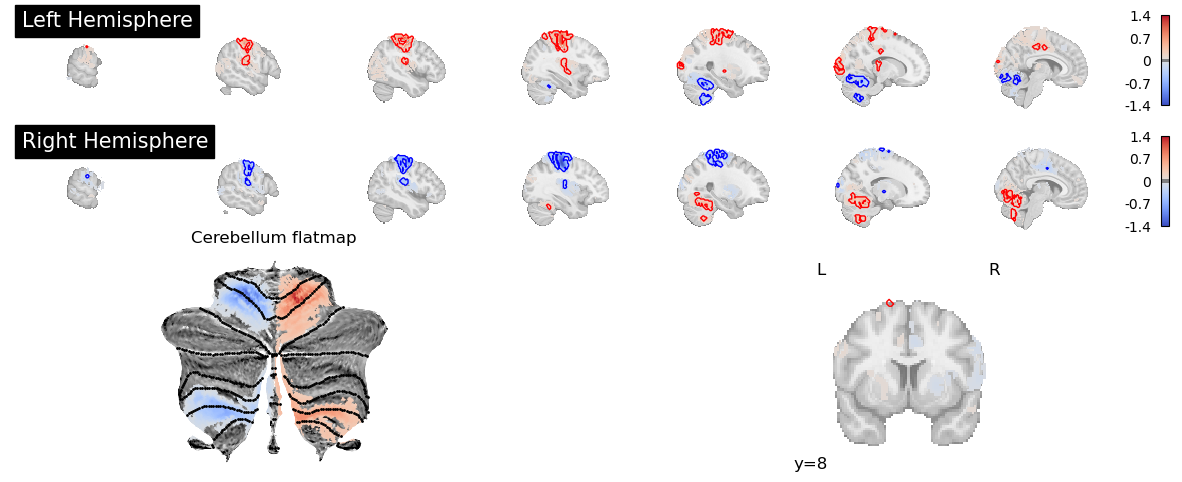

In [5]:
filename = data_dir+'/../group_results/'+'not_asd_SR_RvL'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

### Reward Prediction Error
Reward prediction error as calculate from a Resola-Wagner model. Positive activation means more reward than expected, and negative reward means less reward than expected.

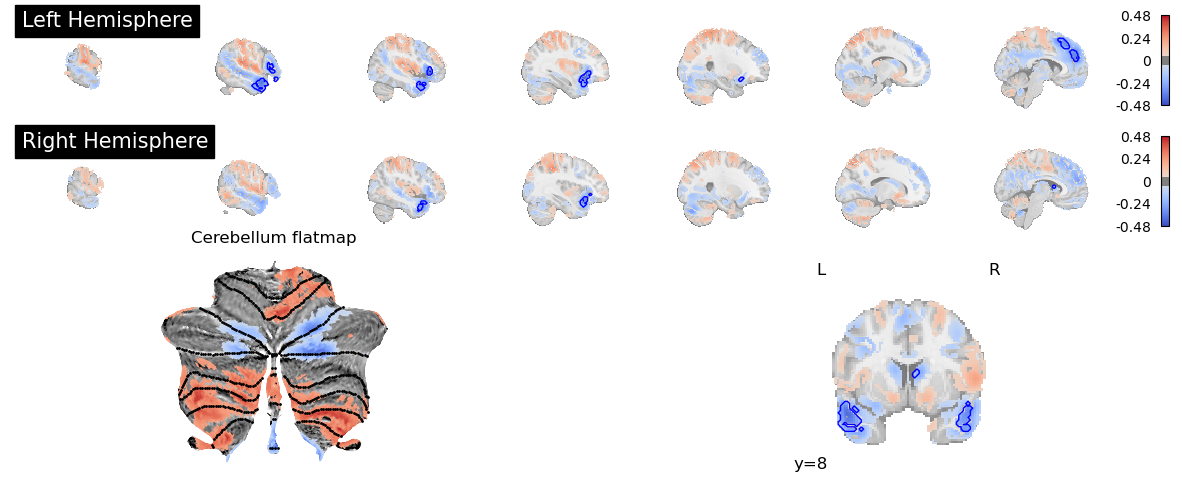

In [19]:
filename = data_dir+'/../group_results/'+'not_asd_SR_RPE'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

### Absolute Reward Prediction Error
This regressor represents the absolute value of the reward prediction error. Positive activations represent greater resposne when the error is greater, regardless of whether the signal is positive or negative.

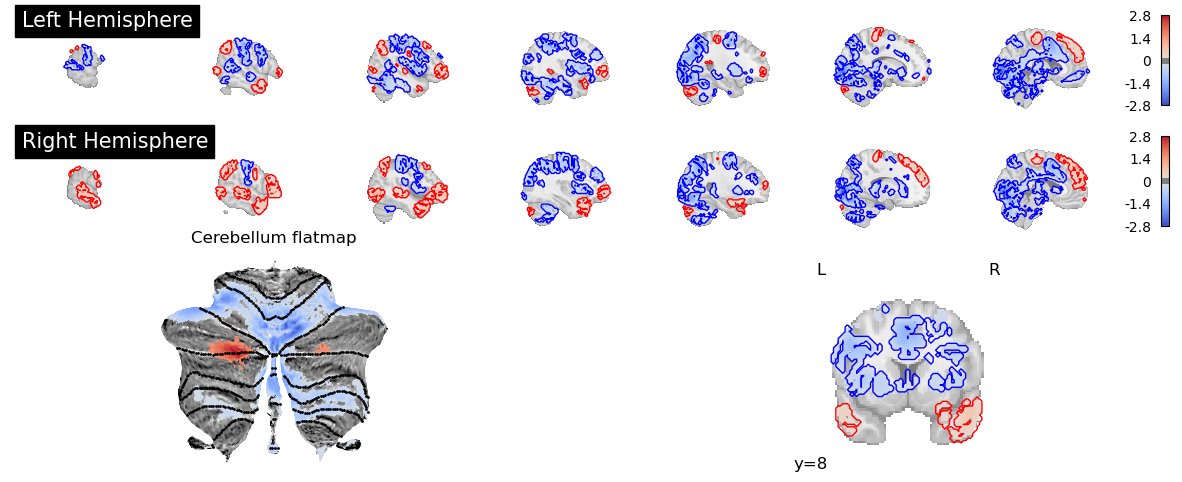

In [28]:
filename = data_dir+'/../group_results/'+'not_asd_SR_RPE_abs'

helpful_functions.plot_transparent_threshold(filename, thresh=.2, mc_alpha=0.005)

## Autistic Adolescents

<Axes: label='conditions', ylabel='scan number'>

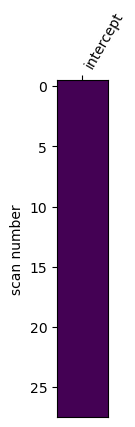

In [8]:
design_matrix = make_second_level_design_matrix(subjs_list_asd)

plot_design_matrix(design_matrix)

In [24]:
mni_mask = bids_dir+"/derivatives/fmriprep/sub-SCN101/anat/sub-SCN101_space-MNIPediatricAsym_cohort-5_res-2_label-GM_probseg_bin.nii.gz"

contrasts=['RPE','RPE_abs','ButtonPress','RvL']
group = 'asd'
tasks = ['SR']
alpha = 0.005
mc = 'fdr'


threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        temp_subj_list = subjs_list_asd.copy()
        temp_file_list = []
        for subj in subjs_list_asd:
            temp_file = glob.glob(os.path.join(data_dir,subj,
                                               'zmap_'+task+'_'+contrast+'_run-all.nii.gz'))
            if len(temp_file) == 0:
                temp_subj_list.remove(subj)
                continue
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        print('Calculating group '+contrast+' contrast')
        
        design_matrix = make_second_level_design_matrix(temp_subj_list)
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)
        
        contrast_stats = model.compute_contrast(output_type='all')
        z_map = contrast_stats['z_score']
        e_map = contrast_stats['effect_size']

        z_map.to_filename(os.path.join(data_dir,'../group_results',
                                   group+'_'+task+'_'+contrast+'_zmap.nii.gz'))
        e_map.to_filename(os.path.join(data_dir,'../group_results',
                                   group+'_'+task+'_'+contrast+'_effect.nii.gz'))
            
        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)
        
        z_map_thresh.to_filename(os.path.join(data_dir,'../group_results',
                                   group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))
            
        threshold_data[group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)] = threshold

Calculating group RPE contrast


/Users/hpopal/anaconda3/lib/python3.11/site-packages/nilearn/glm/thresholding.py:303: UserWarning: The given float value must not exceed 4.358505710715505. But, you have given threshold=inf.
  stat_img = threshold_img(


Calculating group RPE_abs contrast
Calculating group ButtonPress contrast
Calculating group RvL contrast


### Proof of Concept: Button Press

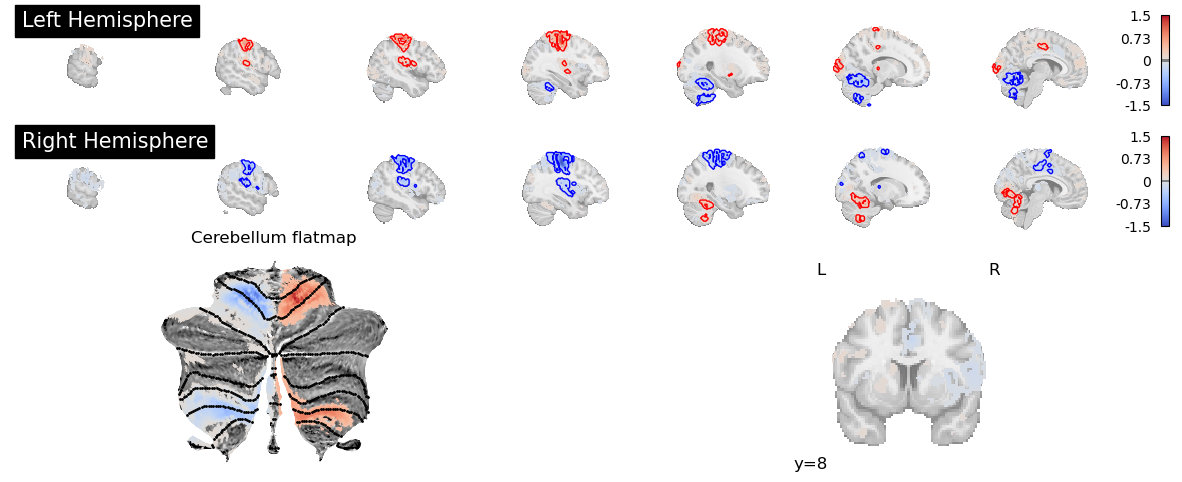

In [10]:
filename = data_dir+'/../group_results/'+'asd_SR_RvL'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.01)

### Reward Prediction Error

/Users/hpopal/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)
/Users/hpopal/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)


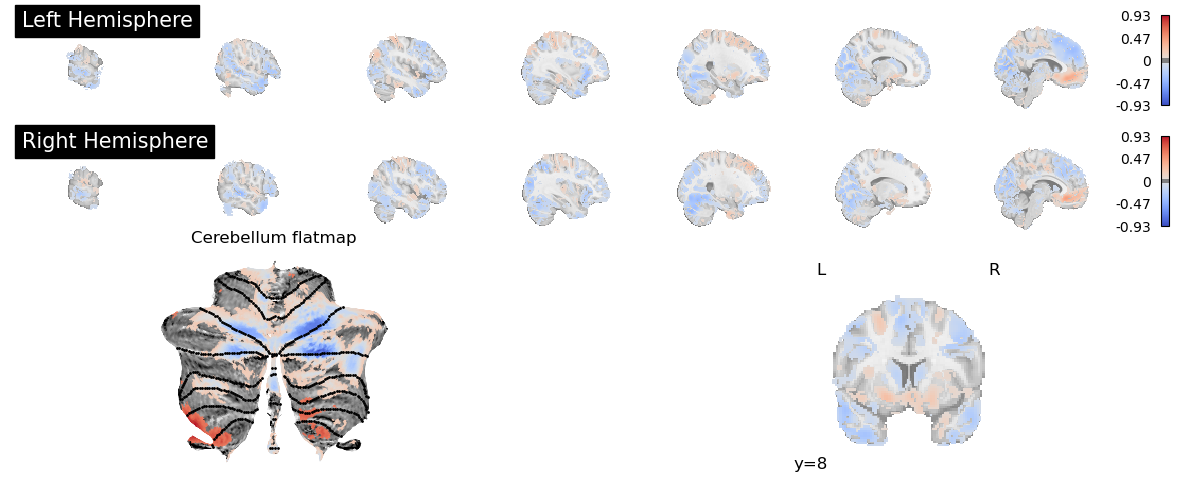

In [25]:
filename = data_dir+'/../group_results/'+'asd_SR_RPE'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

### Absolute Reward Prediction Error

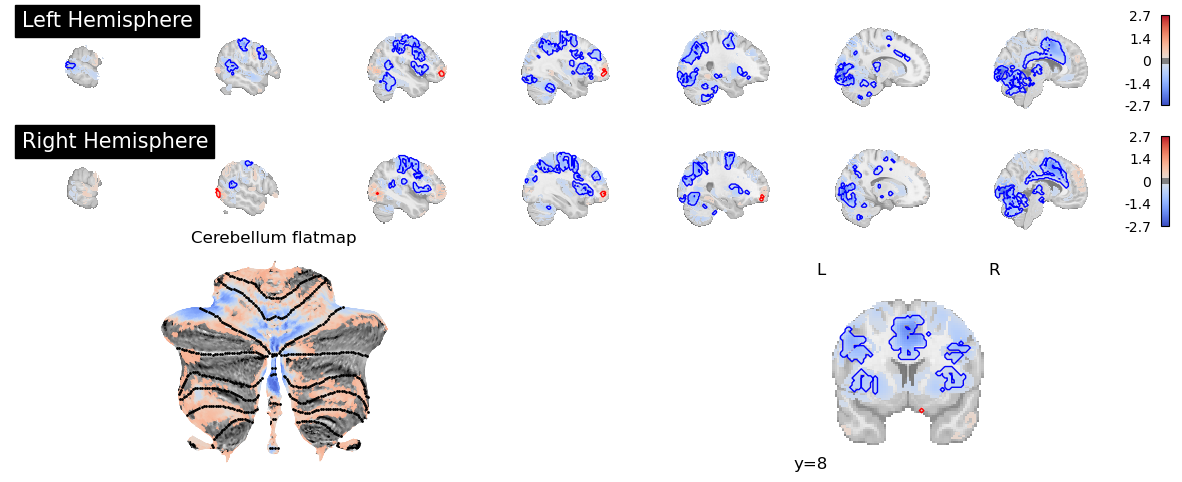

In [27]:
filename = data_dir+'/../group_results/'+'asd_SR_RPE_abs'

helpful_functions.plot_transparent_threshold(filename, thresh=.2, mc_alpha=0.005)

## All Subjects

/var/folders/85/t_6qbb0j2pvbbd0sq3zrwbc00000gq/T/ipykernel_34445/1088075617.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  subjs_info_num = subjs_info_num.replace({'group': {'asd': -1, 'not_asd': 1}})


<Axes: label='conditions', ylabel='scan number'>

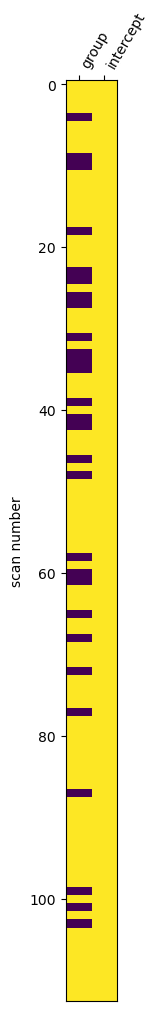

In [13]:
subjs_info_num = subjs_info.copy()
subjs_info_num = subjs_info_num.replace({'group': {'asd': -1, 'not_asd': 1}})
subjs_info_num = subjs_info_num.rename({'participant_id': 'subject_label'}, axis='columns')

# Drop irrelevant columns
subjs_info_num = subjs_info_num.drop(columns=['age','gender'])

design_matrix = make_second_level_design_matrix(list(subjs_info_num['subject_label']), subjs_info_num)

plot_design_matrix(design_matrix)

In [14]:
mni_mask = bids_dir+"/derivatives/fmriprep/sub-SCN101/anat/sub-SCN101_space-MNIPediatricAsym_cohort-5_res-2_label-GM_probseg_bin.nii.gz"

contrasts=['RPE','RPE_abs','ButtonPress']
contrasts_2nd = ['intercept', 'group']
group = 'all'
tasks = ['SR']
alpha = 0.05
mc = 'fdr'


threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        temp_subj_list = subjs_list.copy()
        temp_file_list = []
        for subj in subjs_list:
            temp_file = glob.glob(os.path.join(data_dir,subj,
                                               'zmap_'+task+'_'+contrast+'_run-all.nii.gz'))
            if len(temp_file) == 0:
                temp_subj_list.remove(subj)
                continue
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        # Filter subjs info data frame for only participants that have data
        temp_subjs_info_num = subjs_info_num[subjs_info_num['subject_label'].isin(temp_subj_list)]
        
        print('Calculating group '+contrast+' contrast for '+str(len(temp_file_list))+' subjects')
        
        design_matrix = make_second_level_design_matrix(temp_subj_list, 
                                                        temp_subjs_info_num)
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)
        
        for contrast_2nd in contrasts_2nd:
            contrast_stats = model.compute_contrast(contrast_2nd, output_type='all')
            z_map = contrast_stats['z_score']
            e_map = contrast_stats['effect_size']

            z_map.to_filename(os.path.join(data_dir,'../group_results',
                              group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_zmap.nii.gz'))
            e_map.to_filename(os.path.join(data_dir,'../group_results',
                              group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_effect.nii.gz'))
            
            # Multiple Comparisons Correction
            z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)

            z_map_thresh.to_filename(os.path.join(data_dir,'../group_results',
                                       group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))

            threshold_data[group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_zmap_'+mc+'-'+str(alpha)] = threshold

Calculating group RPE contrast for 108 subjects


/Users/hpopal/anaconda3/lib/python3.11/site-packages/nilearn/glm/thresholding.py:303: UserWarning: The given float value must not exceed 4.117954366927196. But, you have given threshold=inf.
  stat_img = threshold_img(


Calculating group RPE_abs contrast for 108 subjects
Calculating group ButtonPress contrast for 88 subjects


/Users/hpopal/anaconda3/lib/python3.11/site-packages/nilearn/glm/thresholding.py:303: UserWarning: The given float value must not exceed 4.7683513859091935. But, you have given threshold=inf.
  stat_img = threshold_img(


### Group Differences

#### Reward Prediction Error

/Users/hpopal/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)
/Users/hpopal/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)


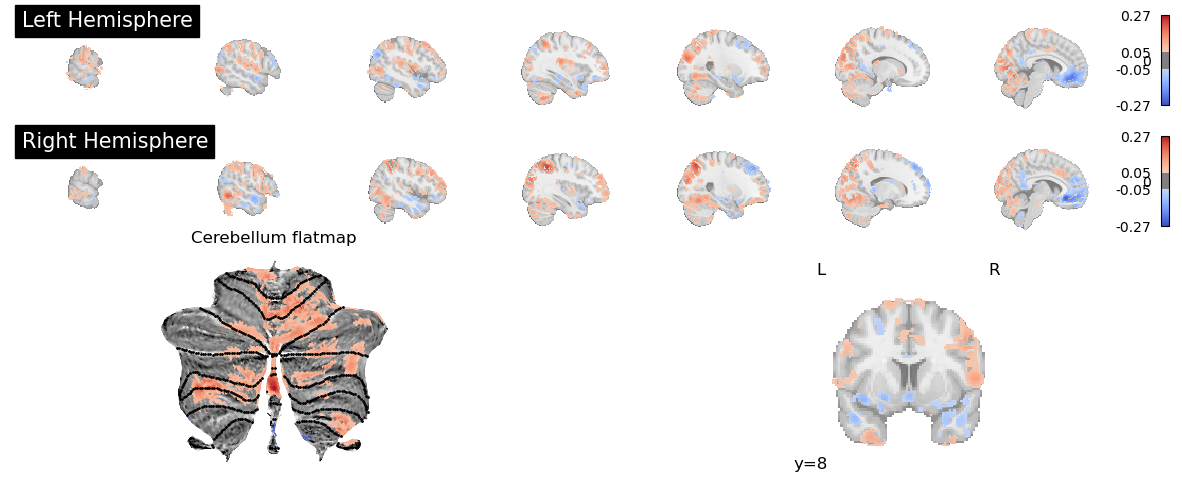

In [15]:
filename = data_dir+'/../group_results/'+'all_SR_RPE_group'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.05)

No significant results

#### Absolute Reward Prediction Error

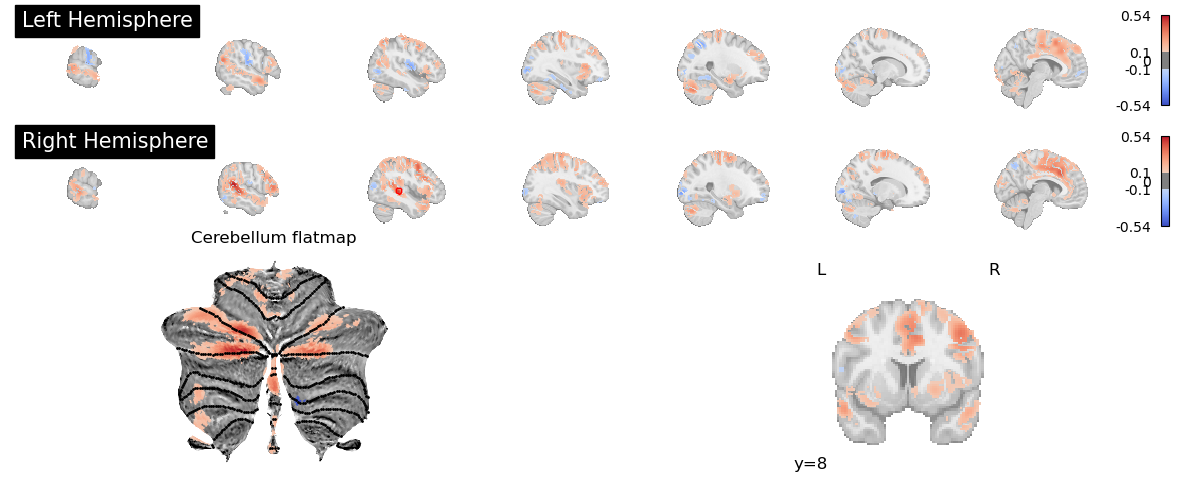

In [30]:
filename = data_dir+'/../group_results/'+'all_SR_RPE_abs_group'

helpful_functions.plot_transparent_threshold(filename, thresh=.1, mc_alpha=0.05)

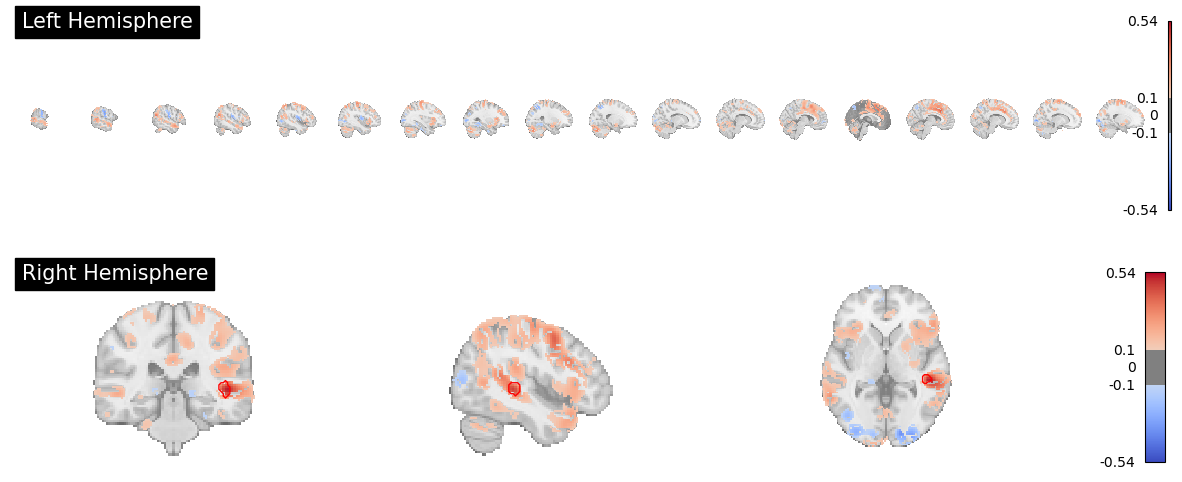

In [31]:
filename = data_dir+'/../group_results/'+'all_SR_RPE_abs_group'
mc_alpha = 0.05
thresh=.1

# Find stat map
stat_filename = os.path.join(filename+'_effect.nii.gz')
stat_filename_mc = os.path.join(filename+'_zmap_'+mc+'-'+str(mc_alpha)+'.nii.gz')

# Set figure specs
fig = plt.figure(figsize=(15, 6))
gs = GridSpec(2, 2)

# Plot whole brain maps
ax_img1 = plt.subplot(gs[0, :])
ax_img2 = plt.subplot(gs[1, :])
        
hemi_lh = plot_stat_map(stat_filename, threshold=thresh, axes=ax_img1,
                        cut_coords=range(-65,25, 5), display_mode='x', colorbar=True,
                        cmap='coolwarm', symmetric_cbar=True, title='Left Hemisphere',
                        annotate=False)
hemi_rh = plot_stat_map(stat_filename, threshold=thresh, axes=ax_img2,
                        colorbar=True, cut_coords=(46,-32,1),
                        cmap='coolwarm', symmetric_cbar=True, title='Right Hemisphere',
                        annotate=False, draw_cross=False)
hemi_lh.add_contours(stat_filename_mc, levels=[-0.1,0.1], colors=['blue','red'], 
                    alpha=1, linewidths=1)
hemi_rh.add_contours(stat_filename_mc, levels=[-0.1,0.1], colors=['blue','red'], 
                    alpha=1, linewidths=1)

No significant results.